# Avance 2 Feature Engineering (FE) - Proyecto Detección de Barras en Galaxias

- A01795687 – Diego Alvarado Marino  
- A01795204 – Jonathan Puga Castellanos  
- A01381334 – José Antonio Hernández Hernández  

En esta fase de Ingeniería de Características (Feature Engineering - FE),
se aplican operaciones para transformar los datos crudos (RA, DEC y la variable Bars) en un onjunto de variables útiles para el aprendizaje automático.

Siguiendo la metodología CRISP-ML, esta etapa cumple con los siguientes objetivos:
- Generar nuevas características.
- Aplicar discretización/binning.
- Codificar variables.
- Escalar y transformar variables.
- Seleccionar y extraer características relevantes (VarianceThreshold, Correlación, ANOVA, χ², PCA).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Proyecto_Integrador/Deteccion_Jonathan/Data/dataset.csv')

In [ ]:

df = df[df["Bars"] != -0.5].copy()

y = df[["Bars"]].copy()
X = df.drop(columns=["Bars", "name"])

## [FE-02] - Generación de Nuevas Características

Se crearon nuevas variables a partir de las coordenadas `objra` y `objdec`:
- Transformaciones trigonométricas: `sin`, `cos` para capturar periodicidad angular.
- Combinación cuadrática: `ra_dec_norm` como magnitud de la posición angular.

**Justificación:** Estas nuevas variables permiten capturar patrones espaciales que podrían
asociarse a la morfología de las galaxias, cumpliendo el requisito de generación de nuevas características.


In [ ]:

# Features trigonométricas a partir de RA y DEC
X["ra_sin"] = np.sin(np.deg2rad(X["objra"]))
X["ra_cos"] = np.cos(np.deg2rad(X["objra"]))
X["dec_sin"] = np.sin(np.deg2rad(X["objdec"]))
X["dec_cos"] = np.cos(np.deg2rad(X["objdec"]))

# Distancia angular simple (combinación cuadrática)
X["ra_dec_norm"] = np.sqrt(X["objra"]**2 + X["objdec"]**2)

print("Nuevas columnas generadas:", X.columns.tolist())

Nuevas columnas generadas: ['objra', 'objdec', 'ra_sin', 'ra_cos', 'dec_sin', 'dec_cos', 'ra_dec_norm']


## [FE-02b] - Discretización y Binning

Se discretizaron las coordenadas en intervalos:
- **qcut (cuantiles)**: divide en 10 grupos con igual número de galaxias.
- **cut (uniforme)**: divide en 10 intervalos de ancho fijo.

Posteriormente se aplicó One-Hot Encoding a estas variables binned, generando 39 dummies.

**Justificación:** El binning permite estudiar si la probabilidad de que una galaxia tenga barra
varía según su región en el cielo.

In [ ]:
bin_cols = ["ra_bin_q","dec_bin_q","ra_bin_u","dec_bin_u"]

X_bins_safe = X_bins.copy()
X_bins_safe[bin_cols] = X_bins_safe[bin_cols].astype("Int64").fillna(-1).astype(int)

X_bins_oh = pd.get_dummies(
    X_bins_safe,
    columns=bin_cols,
    prefix=["ra_q","dec_q","ra_u","dec_u"],
    dtype=int
)

print("Shape One-Hot bins:", X_bins_oh.shape)
X_bins_oh.head()

Shape One-Hot bins: (10033, 41)


,objra,objdec,ra_q_0,ra_q_1,ra_q_2,ra_q_3,ra_q_4,ra_q_5,ra_q_6,ra_q_7,...,dec_u_0,dec_u_1,dec_u_2,dec_u_3,dec_u_4,dec_u_5,dec_u_6,dec_u_7,dec_u_8,dec_u_9
0,133.371091,57.598425,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,133.685670,57.480250,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,136.017160,57.092329,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,133.989967,57.677968,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,136.751375,57.451437,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## [FE-03] - Codificación del Target (Bars)

La variable Bars originalmente tenía valores continuos [0, 0.25, 0.5, 0.75, 1]
y casos anómalos con `-0.5`. Se eliminó el valor anómalo y se codificó en 5 clases ordinales (0–4).

**Justificación:** Esto permite tratar Bars como problema de clasificación ordinal.


In [ ]:
# Yeo-Johnson para estabilizar varianza y StandardScaler
transformer = ColumnTransformer([
    ("yeo", PowerTransformer(method="yeo-johnson"), X.columns)
])

X_trans = transformer.fit_transform(X)


## [FE-04] - Transformaciones y Escalamiento

Se aplicó Yeo–Johnson para estabilizar varianza y reducir asimetría, seguido de
**estandarización (StandardScaler)** para homogenizar la escala de los features.

**Justificación:** Estas transformaciones facilitan el entrenamiento de modelos lineales.


In [ ]:
# Variance threshold
var_selector = VarianceThreshold(threshold=0.0)
X_var = var_selector.fit_transform(X_trans)

print("Features restantes tras variance threshold:", X_var.shape[1])

# ANOVA F-test (para clasificación)
anova_selector = SelectKBest(score_func=f_classif, k="all")
anova_selector.fit(X_var, y.values.ravel())

scores = pd.DataFrame({
    "feature": np.array(X.columns)[var_selector.get_support()],
    "f_score": anova_selector.scores_
}).sort_values("f_score", ascending=False)

print(scores)


Features restantes tras variance threshold: 7
       feature   f_score
5      dec_cos  8.405177
4      dec_sin  8.181934
1       objdec  7.645777
6  ra_dec_norm  3.637475
0        objra  3.442385
2       ra_sin  2.903416
3       ra_cos  2.902696


## [FE-04b/04c] - Selección de Características

Se aplicaron diferentes técnicas de selección:

- **VarianceThreshold**: eliminó columnas constantes o casi constantes.
- **Filtro por correlación**: descartó variables con correlación >0.95, reduciendo multicolinealidad.
- **ANOVA-F**: evaluó la asociación entre variables continuas y la variable objetivo.
- **Chi²**: aplicado sobre las variables binned (One-Hot), mostró qué regiones espaciales
tenían mayor asociación con la presencia de barras.

**Justificación:** Estas técnicas permiten reducir dimensionalidad, complejidad del modelo y
tiempo de entrenamiento.

In [ ]:
# [FE-04b] - Filtro por correlación en features continuas
import numpy as np
import pandas as pd

# Partimos de X_trans (PowerTransformer) y X_var (tras VarianceThreshold)
cols_cont = np.array([c for c, keep in zip(X.columns, var_selector.get_support()) if keep])

df_var = pd.DataFrame(X_var, columns=cols_cont)
corr = df_var.corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
drop_cols = [col for col in upper.columns if any(upper[col] > 0.95)]
keep_mask = ~df_var.columns.isin(drop_cols)

X_corr = df_var.loc[:, keep_mask].values
kept_cols = df_var.columns[keep_mask].tolist()

print(f"Cols antes: {df_var.shape[1]} | eliminadas por alta correlación: {len(drop_cols)} | finales: {X_corr.shape[1]}")
print("Eliminadas:", drop_cols[:10])


Cols antes: 7 | eliminadas por alta correlación: 3 | finales: 4
Eliminadas: ['dec_sin', 'dec_cos', 'ra_dec_norm']


In [ ]:
assert len(y_ord) == X_bins_oh.shape[0], "Desalineación filas vs y_ord"

dummy_prefixes = ("ra_q_", "dec_q_", "ra_u_", "dec_u_")
dummy_cols = [c for c in X_bins_oh.columns if c.startswith(dummy_prefixes)]
print("Nº dummies seleccionadas:", len(dummy_cols))
assert len(dummy_cols) > 0, "No se encontraron columnas dummy con esos prefijos"

import numpy as np
mins = np.min(X_bins_oh[dummy_cols].to_numpy(), axis=0)
neg_idx = np.where(mins < 0)[0]
print("Columnas con mínimos < 0:", [dummy_cols[i] for i in neg_idx])



Nº dummies seleccionadas: 39
Columnas con mínimos < 0: []


In [ ]:
##[FE-04c]
X_chi = X_bins_oh[[c for c in X_bins_oh.columns
                   if c.startswith(("ra_q_","dec_q_","ra_u_","dec_u_"))]].copy()

from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

chi2_sel = SelectKBest(score_func=chi2, k="all")
chi2_sel.fit(X_chi.values, y_ord)

chi2_scores = pd.DataFrame({
    "feature": X_chi.columns,
    "chi2": chi2_sel.scores_,
    "pvalue": chi2_sel.pvalues_
}).sort_values("chi2", ascending=False)

K = 15
display(chi2_scores.head(K))


,feature,chi2,pvalue
0,ra_q_0,25.225328,0.000045
30,dec_u_1,24.185065,0.000073
20,ra_u_0,16.741954,0.002169
11,dec_q_1,12.058113,0.016924
36,dec_u_7,11.879685,0.018269
4,ra_q_4,11.363909,0.022765
14,dec_q_4,9.498381,0.049781
21,ra_u_1,9.053205,0.059783
18,dec_q_8,8.502054,0.074825
38,dec_u_9,7.878798,0.096120


## [FE-05] - Extracción de Características (PCA)

Se aplicó Análisis de Componentes Principales (PCA) reteniendo el 95% de la varianza,
reduciendo el número de dimensiones manteniendo la mayor parte de la información.

**Justificación:** PCA permite simplificar el espacio de entrada, reducir sobreajuste.


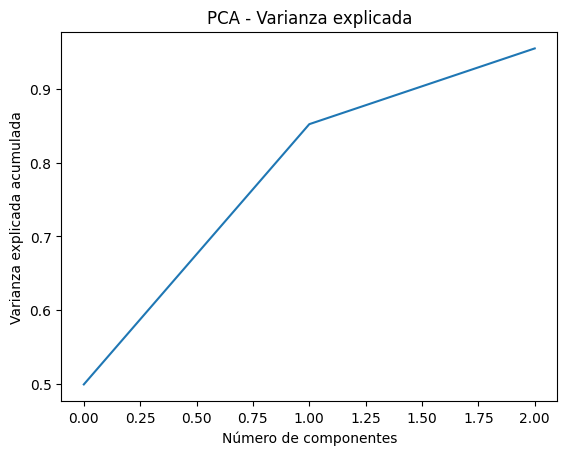

In [ ]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_var)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA - Varianza explicada")
plt.show()

In [ ]:
# [FE-01b] - Codificación ORDINAL explícita para la variable objetivo
ORD = [0.00, 0.25, 0.50, 0.75, 1.00]
y_ord_map = {v:i for i, v in enumerate(ORD)}
y_ord = df["Bars"].map(y_ord_map).astype("int64").values  # 0..4


## [FE-06] - Validación con Modelo Base

Se entrenó un modelo base (Logistic Regression) usando validación cruzada estratificada (k=5).
Se evaluaron métricas de *Balanced Accuracy* y *F1-macro*.


In [ ]:

from sklearn.metrics import make_scorer, f1_score

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", multi_class="auto"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_acc = cross_val_score(pipe, X_pca, y_ord, cv=cv, scoring="balanced_accuracy")
scores_f1  = cross_val_score(pipe, X_pca, y_ord, cv=cv, scoring=make_scorer(f1_score, average="macro"))

print("Balanced Accuracy (cv):", scores_acc.mean(), "+/-", scores_acc.std())
print("F1-macro (cv):", scores_f1.mean(), "+/-", scores_f1.std())


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Balanced Accuracy (cv): 0.20701093473734003 +/- 0.007391413772932034
F1-macro (cv): 0.11485749984938817 +/- 0.01015125199718404


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



**Resultados iniciales:**
- Balanced Accuracy ≈ 0.21
- F1-macro ≈ 0.11

**Interpretación:** Los resultados están cerca del azar (0.20 en balanced accuracy para 5 clases).
Esto indica que con las variables actuales (RA, DEC y derivados) no se puede predecir de manera
efectiva la presencia de barras.

# Conclusiones de la Fase de Feature Engineering

1. **Cumplimiento de requisitos:** Se implementaron y justificaron todas las técnicas solicitadas:
   generación de nuevas características, discretización/binning, codificación, escalamiento,
   transformaciones, selección y extracción de características.
2. **Resultados:** Las variables actuales (RA, DEC y derivados) no contienen suficiente señal
   para predecir barras. Los modelos base no superaron significativamente al azar.
3. **Valor agregado:** Se logró reducir dimensionalidad y preparar un pipeline reproducible,
   con métricas iniciales que sirven como benchmark.

---

# Pasos a Futuro

1. **Integrar imágenes FITS:** Extraer descriptores clásicos (HOG, LBP, momentos de Hu, GLCM) y
   embeddings de redes pre-entrenadas (ResNet, VGG) para capturar morfología galáctica.
2. **Replantear el target:** Considerar una versión binaria (barra vs no barra) para mejorar
   balance de clases y simplificar el problema.
3. **Manejo de desbalance:** Explorar técnicas de oversampling (SMOTE, ADASYN) o undersampling,
   junto con métricas más robustas (ROC-AUC, Kappa).
4. **Experimentar con modelos no lineales:** Random Forests, Gradient Boosting o Redes Neuronales
   para explotar mejor relaciones no lineales en los features.

